# Проект 3. О вкусной и здоровой пище

## Описание проекта
Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

## Основные цели и задачи проекта:
- разобраться с подробным описанием того, как будет организовано изучение модуля;

- зарегистрироваться в соревновании на kaggle;

- проанализировать baseline к соревнованию;

- следуя подсказкам в модуле, обработать оставшиеся признаки и подготовить собственное решение;

- победить в соревновании :)

## Описание датасета
- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvisor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Определение функций

In [2]:
def replace_price_range(string):
    '''
    Замена значений в столбце 'Price Range'
    '''
    if pd.isnull(string):
        return np.nan
    elif string == '$$$$':
        return 4
    elif string == '$$ - $$$':
        return 2.5
    elif string == '$':
        return 1

def get_city_info(string, number):
    '''
    Дополнительная информация по городам
    '''
    cities = {'Paris': ['France', 1, 2148327, 105.4],
              'Stockholm': ['Sweden', 1, 975904, 188],
              'London': ['England', 1, 8961989, 1572],
              'Berlin': ['Germany', 1, 3769495, 891.7],
              'Munich': ['Germany', 0, 1484226, 310.43],
              'Oporto': ['Portugal', 0, 287591, 41.42],
              'Milan': ['Italy', 0, 1399860, 181.76],
              'Bratislava': ['Slovakia', 1, 437726, 367.584],
              'Vienna': ['Austria', 1, 1897491, 414.78],
              'Rome': ['Italy', 1, 2870500, 1285],
              'Barcelona': ['Spain', 0, 1620343, 101.4],
              'Madrid': ['Spain', 1, 3223334, 604.31],
              'Dublin': ['Ireland', 1, 554554, 117.8],
              'Brussels': ['Belgium', 1, 1208542, 162.4],
              'Zurich': ['Switzerland', 1, 415215, 87.88],
              'Warsaw': ['Polish', 1, 1793579, 517.24],
              'Budapest': ['Hungary', 1, 1752286, 525.2],
              'Copenhagen': ['Denmark', 1, 794128, 179.8],
              'Amsterdam': ['Netherlands', 1, 872680, 219.32],
              'Lyon': ['France', 0, 516092, 47.87],
              'Hamburg': ['Germany', 0, 1845229, 755.22],
              'Lisbon': ['Portugal', 1, 505526, 100.05],
              'Prague': ['Czech Republic', 1, 1324277, 496],
              'Oslo': ['Norway', 1, 697549, 480.75],
              'Helsinki': ['Finland', 1, 656229, 715.48],
              'Edinburgh': ['Scotland', 1, 488050, 264],
              'Geneva': ['Switzerland', 0, 201818, 15.92],
              'Ljubljana': ['Slovenia', 0, 295504, 163.8],
              'Athens': ['Greece', 1, 664046, 38.964],
              'Luxembourg': ['Luxembourg', 1, 124528, 51.46],
              'Krakow': ['Poland', 0, 779115, 326.8]}
    return cities[string][number]

def round_rating(value):
    '''
    Округление целевой переменной
    '''
    value = np.round(value * 2) / 2
    return value

def cuisines_to_list(string):
    '''
    Преобразование строки с кухнями
    '''
    if pd.isnull(string):
        return np.nan
    string = string.replace('[','').replace(']','').replace('\'','')
    return string.split(', ')

def count_cuisine(string):
    '''
    Количество значений с кухнями
    '''
    if pd.isnull(string):
        return 1
    return len(cuisines_to_list(string))

def find_cuisine(string, cuisine):
    '''
    Поиск кухни в строке
    '''
    if pd.isnull(string):
        return 0
    if cuisine in cuisines_to_list(string):
        return 1
    return 0

def reviews_to_list(string):
    '''
    Преобразование строки с комментариями
    '''
    if (pd.isnull(string)) | (string == '[[], []]'):
        return np.nan
    string = string.replace('[[\'','')\
    .replace('\']]','')\
    .replace('\', "','\', \'')\
    .replace('"], [\'','\'], [\'')\
    .replace('\', nan', '\', \'\'')
    reviews, time = string.split('\'], [\'')
    return [reviews.split('\', \''), time.split('\', \'')]

def fill_other(string, most_popular):
    '''
    Заполнение значений с популярными кухнями
    '''
    if pd.isnull(string):
        return 0
    for elem in cuisines_to_list(string):
        if elem in most_popular:
            return 0
    return 1

def count_words(string, good_words, bad_words):
    '''
    Считаем количество слов
    '''
    i = 0
    for word in string:
        if word in good_words:
            i += 1
        elif word in bad_words:
            i -= 1
    return(i)

def get_outliners(column):
    '''
    Определяем выбросы
    '''
    median = data[column].median()
    quan25 = data[column].quantile(0.25)
    quan75 = data[column].quantile(0.75)
    IQR = quan75 - quan25
    left = quan25 - 1.5*IQR,
    right = quan75 + 1.5*IQR
    print(f"Границы выбросов для столбца '{column}': [{left}, {right}]")

def max_ranking(city):
    return data[data['City'] == city]['Ranking'].max()

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
18372,id_6314,Barcelona,NaN,6315.0,NaN,9.0,"[['good breakfast', 'Great Place'], ['09/27/20...",/Restaurant_Review-g187497-d10810340-Reviews-B...,d10810340,1,3.5
5309,id_5309,London,"['Indian', 'Fast Food', 'Asian', 'Vegetarian F...",11624.0,$,22.0,"[['PLASTIC IN THE FOOD!', 'Hands down best Ind...",/Restaurant_Review-g186338-d4912880-Reviews-Ho...,d4912880,0,0.0
18712,id_2037,Brussels,"['Italian', 'Pizza']",2038.0,$,34.0,"[['Pizza and wine', 'Awful experience'], ['04/...",/Restaurant_Review-g1068497-d3958809-Reviews-L...,d3958809,1,4.0
26691,id_4130,Prague,"['European', 'Central European', 'Czech']",4148.0,$$ - $$$,220.0,"[['No credit cards accepted, extremely high p....",/Restaurant_Review-g274707-d2431998-Reviews-Ve...,d2431998,1,1.0
856,id_856,Hamburg,"['Mediterranean', 'European', 'Bar', 'Vegetari...",2153.0,$$ - $$$,74.0,"[['Tragic', 'Pretentious'], ['07/16/2017', '12...",/Restaurant_Review-g187331-d1038800-Reviews-Do...,d1038800,0,0.0


In [15]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

<AxesSubplot:>

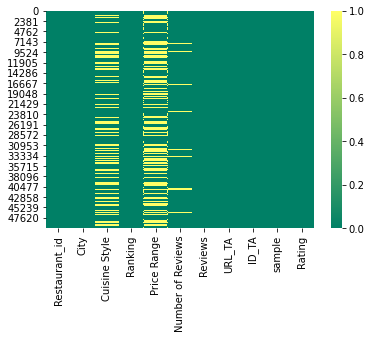

In [16]:
sns.heatmap(data.isnull(), cmap='summer')

Основные пропуски в столбцах 'Cuisine Style', 'Price Range', 'Number of Reviews' и 'Reviews'

In [17]:
# удалим строки, где очень мало полезных данных
data.drop((data[(data['Cuisine Style'].isna()) &
     (data['Price Range'].isna()) &
     (data['Number of Reviews'].isna()) &
     (data['Reviews'] == '[[], []]')]).index, inplace=True)

1. Обработаем **'Number of Reviews'**

<AxesSubplot:>

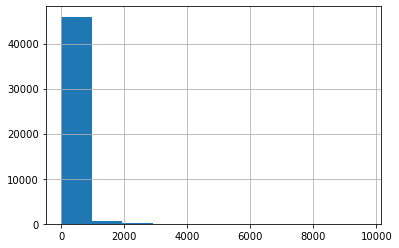

In [18]:
data['Number of Reviews'].hist()

Распределение не похоже на нормальное. Можно обработать выбросы. Пока заменим пропуски

In [19]:
data['Number of Reviews'].fillna(data['Number of Reviews'].mean(), inplace=True)

In [20]:
get_outliners('Number of Reviews')

Границы выбросов для столбца 'Number of Reviews': [(-161.70679487179487,), 296.1779914529915]


In [21]:
data[data['Number of Reviews'] > 296]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
10,id_10,Rome,NaN,1209.0,NaN,306.0,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0
16,id_16,Milan,"['Pizza', 'Vegetarian Friendly', 'Vegan Options']",1825.0,$$ - $$$,322.0,"[['truly Neapolitan pizza, new/slick location'...",/Restaurant_Review-g187849-d11850449-Reviews-P...,d11850449,0,0.0
29,id_29,Oslo,"['French', 'European', 'Norwegian', 'Italian',...",550.0,$$ - $$$,465.0,"[['Lovely food!', 'Nightmare'], ['02/26/2017',...",/Restaurant_Review-g190479-d1495732-Reviews-Mo...,d1495732,0,0.0
38,id_38,Paris,"['French', 'European', 'Vegetarian Friendly']",1722.0,$$ - $$$,572.0,"[['Upstairs Quieter and Pleasant', 'Delicious,...",/Restaurant_Review-g187147-d1326624-Reviews-Le...,d1326624,0,0.0
41,id_41,Paris,"['American', 'Steakhouse']",13116.0,$$ - $$$,372.0,"[['Worst experience ever!!', 'Bad everything']...",/Restaurant_Review-g187147-d695231-Reviews-Buf...,d695231,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49968,id_5553,Milan,"['Italian', 'Wine Bar']",5556.0,$$ - $$$,507.0,"[['Perfect location but... overpriced', 'The p...",/Restaurant_Review-g187849-d2142329-Reviews-N_...,d2142329,1,3.0
49980,id_253,Rome,"['Italian', 'Seafood', 'Mediterranean', 'Europ...",254.0,$$ - $$$,560.0,[['Creative cocktails and pleasant atmosphere....,/Restaurant_Review-g187791-d8273642-Reviews-Su...,d8273642,1,4.5
49985,id_56,Brussels,"['African', 'Ethiopian', 'Vegetarian Friendly'...",57.0,$$ - $$$,989.0,"[['A nice experience with Ethiopian food', 'A ...",/Restaurant_Review-g188644-d778285-Reviews-Kok...,d778285,1,4.0
49992,id_13,Stockholm,"['Swedish', 'Scandinavian', 'Vegetarian Friend...",14.0,$$ - $$$,1162.0,"[['Great Viking Dinner', 'A foot stompingly go...",/Restaurant_Review-g189852-d2560559-Reviews-Ai...,d2560559,1,4.5


Много выбросов. Можно в дальнейшем попробовать объединить, если это даст эффект

2. Обработаем **'Cuisine_Style'**

In [22]:
# список всех типов cousines
cousines = []
for string in data['Cuisine Style'].apply(cuisines_to_list):
    if type(string) == float:
        continue
    for cousine in string:
        if not(cousine in cousines):
            cousines.append(cousine)
cousines

['Bar',
 'Pub',
 'European',
 'Scandinavian',
 'Gluten Free Options',
 'Vegetarian Friendly',
 'Vegan Options',
 'Italian',
 'Mediterranean',
 'Seafood',
 'French',
 'Cafe',
 'Fast Food',
 'Portuguese',
 'Greek',
 'Czech',
 'Eastern European',
 'Central European',
 'Pizza',
 'British',
 'Spanish',
 'Norwegian',
 'African',
 'Moroccan',
 'Middle Eastern',
 'Halal',
 'Indian',
 'Thai',
 'Dutch',
 'Welsh',
 'American',
 'Steakhouse',
 'Soups',
 'Scottish',
 'Fusion',
 'Street Food',
 'Hungarian',
 'Asian',
 'Wine Bar',
 'Barbecue',
 'Central American',
 'Peruvian',
 'South American',
 'Irish',
 'Polish',
 'Vietnamese',
 'Lebanese',
 'Turkish',
 'Healthy',
 'Japanese',
 'Sushi',
 'Austrian',
 'Chinese',
 'Danish',
 'International',
 'Gastropub',
 'Korean',
 'German',
 'Contemporary',
 'Arabic',
 'Diner',
 'Swiss',
 'Swedish',
 'Persian',
 'Australian',
 'Grill',
 'Mexican',
 'Latin',
 'Belgian',
 'Argentinean',
 'Tunisian',
 'Russian',
 'Nepali',
 'Bangladeshi',
 'Colombian',
 'Sri Lankan'

In [23]:
len(cousines)

125

In [24]:
data['Cuisine Style'].apply(count_cuisine).mean()

2.661813422763895

In [25]:
for cousine in cousines:
    data[cousine] = data['Cuisine Style'].apply(lambda x: find_cuisine(x, cousine))
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
for cousine in cousines:
    print('{} - {}'.format(cousine, data[cousine].sum()))

Bar - 4094
Pub - 3058
European - 12561
Scandinavian - 449
Gluten Free Options - 5185
Vegetarian Friendly - 14021
Vegan Options - 5684
Italian - 7433
Mediterranean - 7820
Seafood - 1878
French - 3970
Cafe - 2883
Fast Food - 2122
Portuguese - 1385
Greek - 768
Czech - 745
Eastern European - 629
Central European - 1727
Pizza - 3502
British - 1992
Spanish - 3456
Norwegian - 96
African - 193
Moroccan - 173
Middle Eastern - 980
Halal - 773
Indian - 1328
Thai - 923
Dutch - 368
Welsh - 3
American - 1642
Steakhouse - 729
Soups - 630
Scottish - 199
Fusion - 748
Street Food - 336
Hungarian - 444
Asian - 3786
Wine Bar - 877
Barbecue - 710
Central American - 168
Peruvian - 130
South American - 490
Irish - 352
Polish - 453
Vietnamese - 622
Lebanese - 397
Turkish - 574
Healthy - 758
Japanese - 1860
Sushi - 1450
Austrian - 462
Chinese - 1446
Danish - 225
International - 1966
Gastropub - 608
Korean - 206
German - 820
Contemporary - 652
Arabic - 58
Diner - 375
Swiss - 223
Swedish - 223
Persian - 77
Austr

In [27]:
data[cousines].sum().sort_values(ascending=False)

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Fujian                     2
Salvadoran                 1
Xinjiang                   1
Burmese                    1
Latvian                    1
Length: 125, dtype: int64

Заменим пустые значения самыми популярными кухнями

In [28]:
data['Cuisine Style'] = data['Cuisine Style'].fillna(str(['Vegetarian Friendly', 'European']))

Повторяем создание дамми переменных, но оставим только самые популярные кухни, остальные отнесем к прочим.

In [29]:
most_popular = data[cousines].sum().sort_values(ascending=False).nlargest(30).index.to_list()
most_popular

['Vegetarian Friendly',
 'European',
 'Mediterranean',
 'Italian',
 'Vegan Options',
 'Gluten Free Options',
 'Bar',
 'French',
 'Asian',
 'Pizza',
 'Spanish',
 'Pub',
 'Cafe',
 'Fast Food',
 'British',
 'International',
 'Seafood',
 'Japanese',
 'Central European',
 'American',
 'Sushi',
 'Chinese',
 'Portuguese',
 'Indian',
 'Middle Eastern',
 'Thai',
 'Wine Bar',
 'German',
 'Halal',
 'Greek']

In [30]:
data.drop(data[cousines], axis=1, inplace=True)

In [31]:
for cousine in cousines:
    if cousine in most_popular:
        data[cousine] = data['Cuisine Style'].apply(lambda x: find_cuisine(x, cousine))
data['other'] = data['Cuisine Style'].apply(lambda x: fill_other(x, most_popular))
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Thai,American,Asian,Wine Bar,Japanese,Sushi,Chinese,International,German,other
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,0,0,0,0,0,0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
for cousine in cousines:
    if cousine in most_popular:
        print('{} - {}'.format(cousine, data[cousine].sum()))
print('Other - {}'.format(data['other'].sum()))

Bar - 4094
Pub - 3058
European - 23053
Gluten Free Options - 5185
Vegetarian Friendly - 24513
Vegan Options - 5684
Italian - 7433
Mediterranean - 7820
Seafood - 1878
French - 3970
Cafe - 2883
Fast Food - 2122
Portuguese - 1385
Greek - 768
Central European - 1727
Pizza - 3502
British - 1992
Spanish - 3456
Middle Eastern - 980
Halal - 773
Indian - 1328
Thai - 923
American - 1642
Asian - 3786
Wine Bar - 877
Japanese - 1860
Sushi - 1450
Chinese - 1446
International - 1966
German - 820
Other - 1355


In [33]:
data[most_popular].sum().sort_values(ascending=False)

Vegetarian Friendly    24513
European               23053
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
Pizza                   3502
Spanish                 3456
Pub                     3058
Cafe                    2883
Fast Food               2122
British                 1992
International           1966
Seafood                 1878
Japanese                1860
Central European        1727
American                1642
Sushi                   1450
Chinese                 1446
Portuguese              1385
Indian                  1328
Middle Eastern           980
Thai                     923
Wine Bar                 877
German                   820
Halal                    773
Greek                    768
dtype: int64

3. Обработаем **'Price Range'**

In [34]:
data[data['Price Range'].isna()].count()

Restaurant_id          16263
City                   16263
Cuisine Style          16263
Ranking                16263
Price Range                0
Number of Reviews      16263
Reviews                16261
URL_TA                 16263
ID_TA                  16263
sample                 16263
Rating                 16263
Bar                    16263
Pub                    16263
European               16263
Gluten Free Options    16263
Vegetarian Friendly    16263
Vegan Options          16263
Italian                16263
Mediterranean          16263
Seafood                16263
French                 16263
Cafe                   16263
Fast Food              16263
Portuguese             16263
Greek                  16263
Central European       16263
Pizza                  16263
British                16263
Spanish                16263
Middle Eastern         16263
Halal                  16263
Indian                 16263
Thai                   16263
American               16263
Asian         

In [35]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Средняя категория является самой популярной. Заполним пропуски этим значением

In [36]:
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

4. Обработаем **'Reviews'**

In [37]:
data[data['Reviews'].isna()]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Thai,American,Asian,Wine Bar,Japanese,Sushi,Chinese,International,German,other
8168,id_8168,Lisbon,"['Vegetarian Friendly', 'European']",3389.0,$$ - $$$,2.000000,NaN,/Restaurant_Review-g189158-d12683988-Reviews-O...,d12683988,0,...,0,0,0,0,0,0,0,0,0,0
9608,id_9608,Vienna,"['Vegetarian Friendly', 'European']",1779.0,$$ - $$$,124.471197,NaN,/Restaurant_Review-g190454-d12605368-Reviews-R...,d12605368,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')

<AxesSubplot:>

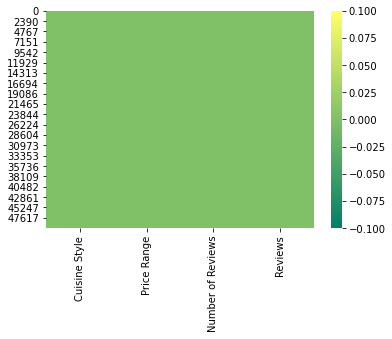

In [39]:
sns.heatmap(data[['Cuisine Style', 'Price Range', 'Number of Reviews', 'Reviews']].isnull(), cmap='summer')

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [40]:
data.nunique(dropna=False)

Restaurant_id          13014
City                      31
Cuisine Style          10732
Ranking                12876
Price Range                3
Number of Reviews       1574
Reviews                41857
URL_TA                 48865
ID_TA                  48865
sample                     2
Rating                    10
Bar                        2
Pub                        2
European                   2
Gluten Free Options        2
Vegetarian Friendly        2
Vegan Options              2
Italian                    2
Mediterranean              2
Seafood                    2
French                     2
Cafe                       2
Fast Food                  2
Portuguese                 2
Greek                      2
Central European           2
Pizza                      2
British                    2
Spanish                    2
Middle Eastern             2
Halal                      2
Indian                     2
Thai                       2
American                   2
Asian         

Возьмем признак 'Price Range'

In [41]:
data['Price Range'].value_counts()

$$ - $$$    39304
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [42]:
data['Price Range'] = data['Price Range'].apply(replace_price_range)

In [43]:
data['Reviews'].apply(reviews_to_list)

0                                                      NaN
1        [[Very good reviews!, Fine dining in Hakaniemi...
2        [[Better than the Links, Ivy Black], [12/28/20...
3        [[Most exquisite, Delicious and authentic], [1...
4        [[Always the best in bratislava, Very good but...
                               ...                        
49995    [[The real Italian experience!, Wonderful food...
49996    [[Parisian atmosphere, Bit pricey but interest...
49997    [[Good by swedish standards, A hidden jewel in...
49998    [[Underground restaurant, Oldest Restaurant in...
49999    [[Average, Nice an informal], [01/31/2016, 07/...
Name: Reviews, Length: 48902, dtype: object

In [44]:
words_set = set()
for i in data['Reviews'].apply(reviews_to_list):
    if type(i) == float:
        continue
    for elem in i[0]:
        elem = elem.lower()
        elem = elem.replace('!', '').replace('.', '').replace(',', '')
        elem = elem.split(' ')
        for word in elem:
            words_set.add(word)
words_set

{'',
 'church',
 'unpredictable',
 '[["ed\'s',
 "n'est",
 'poslední',
 'djurgarden',
 'immedi',
 'like(greece)',
 'canteen”',
 'sirenas',
 'teeny-tiny',
 'pomm',
 'gener',
 'inexprienced',
 '(soup',
 'vegans-veggies',
 'sted',
 'guacamole',
 'especially',
 '«\\xa0the',
 'finnish',
 'piace"',
 'senator',
 'madrid’s',
 'me)',
 'wintery',
 'haired',
 'covering',
 'weirdos',
 'veggie',
 'cappauccino',
 'quenched',
 'bird',
 'nice/',
 'yum',
 'galactic',
 'gossamer',
 "l'olive",
 "1950's",
 'ristora',
 'nicr',
 'halvan',
 'tunisienne',
 'bros',
 'schwabingers',
 'rumbling',
 'pier',
 'annotated',
 'belated',
 'repeatable',
 'sushitop',
 'islands',
 'usua',
 'globe',
 'buildin',
 'suburban',
 'mixture',
 'cadorna',
 'attitude?',
 'langnese',
 'ameri',
 'hottest',
 'train',
 'takeawaylandor',
 'locations',
 'cocktials',
 'greek-',
 'ab',
 'lip-smacking',
 'verdi',
 '"nest"',
 'caterin',
 'bu"',
 'manger-esque',
 'brazil',
 'macrobiotic',
 'retreat',
 'residenti',
 'specialisi',
 'north',
 'fa

In [45]:
# сделаем два списка: положительные и отрицательные слова
good_words = ['amazing','fantastic','perfect','wonderful',
               'gusto','nya','bellisimo','dequate','pleasantly','wunderfull',
               'pleasant','awesome','yummy','fabulous','cool',
               'delucious','excellient','picturesque','👍','good','great',
               'best','excellent','nice','delicious','lovely','tasty',
               'fine','brilliant','enjoyable','good!','outstanding','delicious!',
               'charming','affordable','delightful','comfortable','+','gorgeous','👏',
              'рекомендую','famously','amazinggggg',':)','))','💓', 'recommendable',
              'superbo','graet','guter','⭐️','👌','super']
bad_words = ['foo','bad','poor','stop','worst','disappointing',
              '😞','weak','only?','grubby','awseome','wash','ameri',
              'horrible','mediocre','unfriendly','worse','dirty',
              'weakest','filthy','disasterous','becareful','miserable',
              'terrible','overpriced','rude','disappointed',
              'disappointment','fo','waste','satisfying', '((', ':(']
data['count_words'] = data['Reviews'].apply(lambda x: count_words(x, good_words, bad_words))

In [46]:
data['count_words'].value_counts()

 0    48775
 1      105
 2        9
 3        8
 4        2
 5        2
-1        1
Name: count_words, dtype: int64

Обработаем остальные признаки

In [47]:
data['country'] = data['City'].apply(lambda x: get_city_info(x, 0))
data = pd.get_dummies(data, columns=['country'])
data['capital'] = data['City'].apply(lambda x: get_city_info(x, 1))
data['people'] = data['City'].apply(lambda x: get_city_info(x, 2))
data['frequency '] = data['Number of Reviews'] / data['people']
data['area'] = data['City'].apply(lambda x: get_city_info(x, 3))
data['max_ranking'] = data['City'].map(data.groupby(by='City').max()['Ranking'])
data['ranking_to_max'] = data['Ranking'] / data['max_ranking']

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48902 entries, 0 to 49999
Data columns (total 73 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           48902 non-null  object 
 1   City                    48902 non-null  object 
 2   Cuisine Style           48902 non-null  object 
 3   Ranking                 48902 non-null  float64
 4   Price Range             48902 non-null  float64
 5   Number of Reviews       48902 non-null  float64
 6   Reviews                 48902 non-null  object 
 7   URL_TA                  48902 non-null  object 
 8   ID_TA                   48902 non-null  object 
 9   sample                  48902 non-null  int64  
 10  Rating                  48902 non-null  float64
 11  Bar                     48902 non-null  int64  
 12  Pub                     48902 non-null  int64  
 13  European                48902 non-null  int64  
 14  Gluten Free Options     48902 non-null

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

<AxesSubplot:>

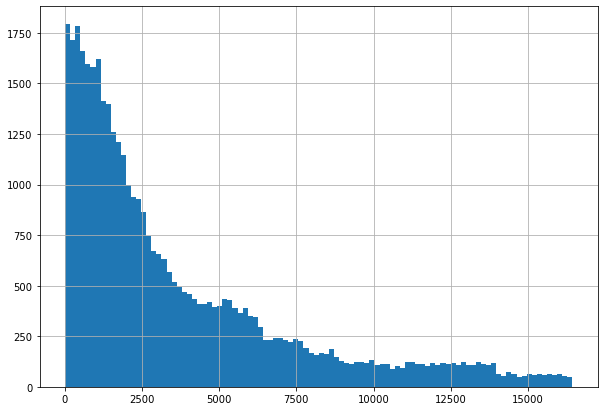

In [49]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

<AxesSubplot:>

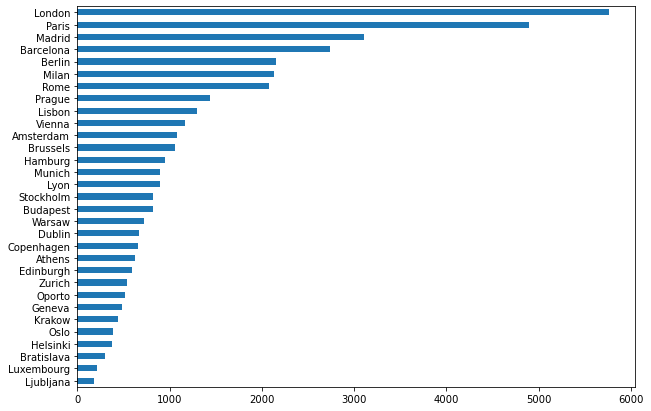

In [50]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

<AxesSubplot:>

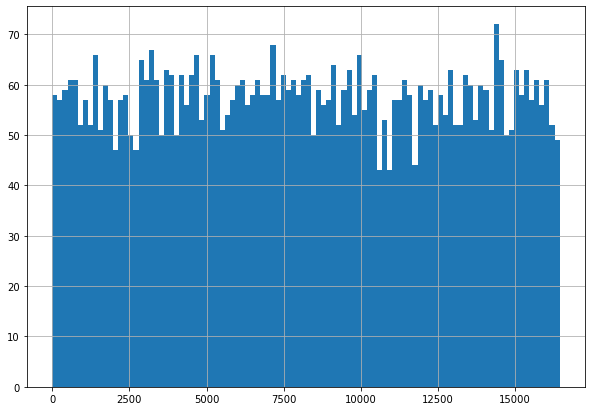

In [51]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

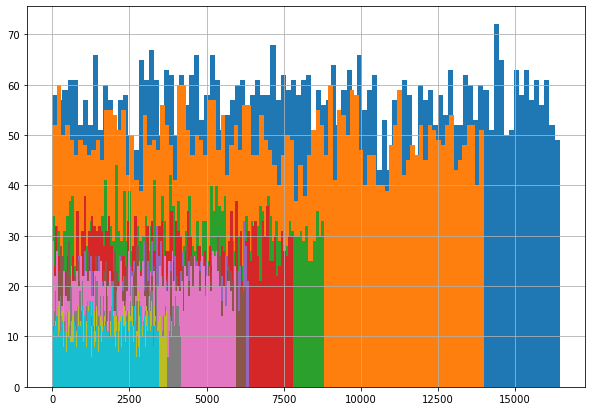

In [52]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого имеем смещение. Для этого смотрим Ranking внутри города.


### Посмотрим распределение целевой переменной

<AxesSubplot:>

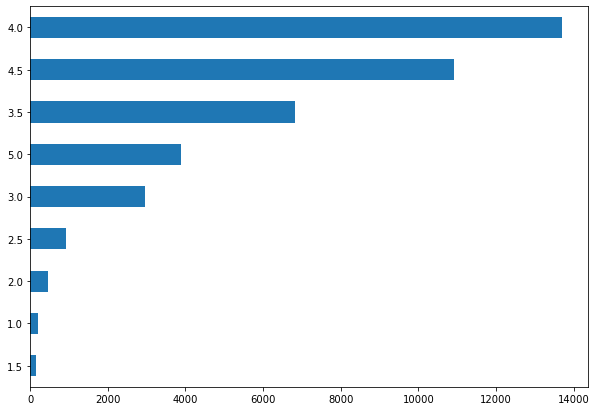

In [53]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

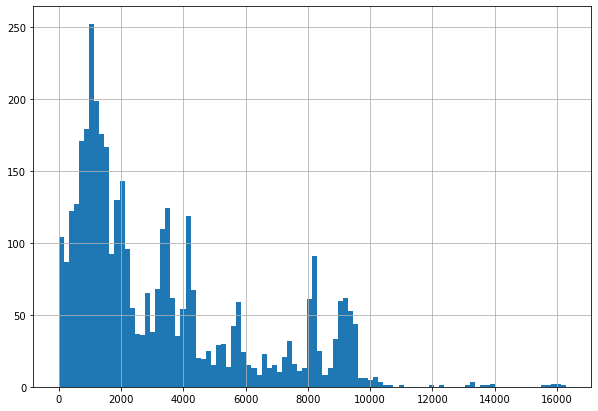

In [54]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

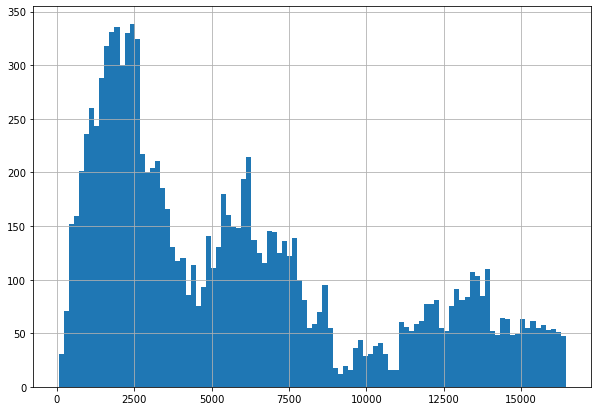

In [55]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

array([[<AxesSubplot:title={'center':'Ranking'}>,
        <AxesSubplot:title={'center':'Price Range'}>,
        <AxesSubplot:title={'center':'Number of Reviews'}>,
        <AxesSubplot:title={'center':'sample'}>,
        <AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Bar'}>,
        <AxesSubplot:title={'center':'Pub'}>,
        <AxesSubplot:title={'center':'European'}>],
       [<AxesSubplot:title={'center':'Gluten Free Options'}>,
        <AxesSubplot:title={'center':'Vegetarian Friendly'}>,
        <AxesSubplot:title={'center':'Vegan Options'}>,
        <AxesSubplot:title={'center':'Italian'}>,
        <AxesSubplot:title={'center':'Mediterranean'}>,
        <AxesSubplot:title={'center':'Seafood'}>,
        <AxesSubplot:title={'center':'French'}>,
        <AxesSubplot:title={'center':'Cafe'}>],
       [<AxesSubplot:title={'center':'Fast Food'}>,
        <AxesSubplot:title={'center':'Portuguese'}>,
        <AxesSubplot:title={'center':'Greek'}>,
        

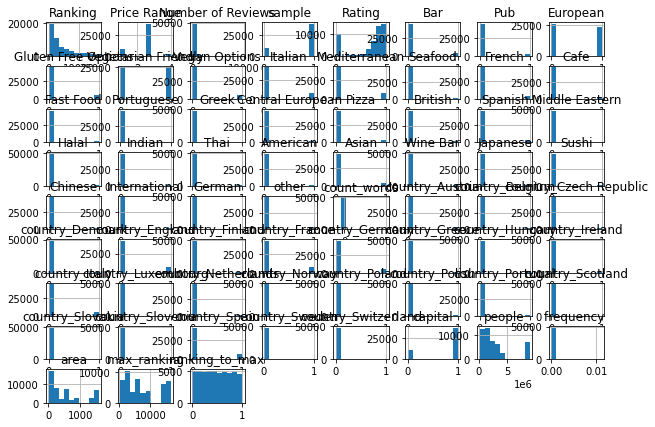

In [56]:
data.hist()

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

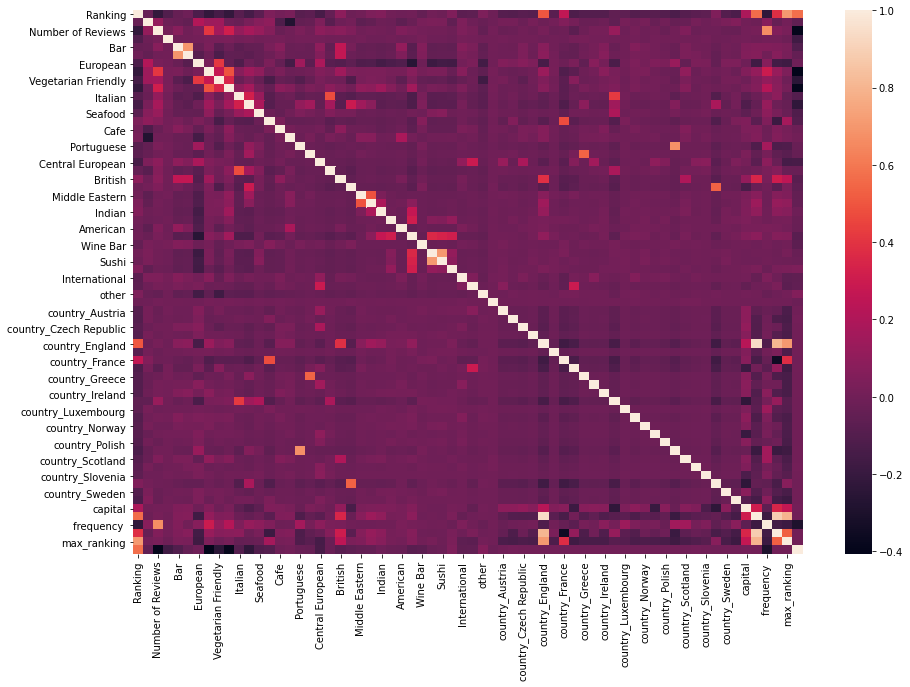

In [57]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [58]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [59]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA','URL_TA'], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output.drop((df_output[(df_output['Cuisine Style'].isna()) &
                              (df_output['Price Range'].isna()) &
                              (df_output['Number of Reviews'].isna()) &
                              (df_output['Reviews'] == '[[], []]') &
                              (df_output['sample'] == 1)]).index, inplace=True)
    df_output['Number of Reviews'].fillna(df_output['Number of Reviews'].mean(), inplace=True)
    df_output['Cuisine Style'].fillna(str(['Vegetarian Friendly', 'European']), inplace=True)
    df_output['Price Range'].fillna('$$ - $$$', inplace=True)
    df_output['Reviews'].fillna('[[], []]', inplace=True)
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output['Price Range'] = df_output['Price Range'].apply(replace_price_range)
    
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код на генерацию новых фитчей
    for cousine in cousines:
        if cousine in most_popular:
            df_output[cousine] = df_output['Cuisine Style'].apply(lambda x: find_cuisine(x, cousine))
    df_output['other'] = df_output['Cuisine Style'].apply(lambda x: fill_other(x, most_popular))
    df_output['count_words'] = df_output['Reviews'].apply(lambda x: count_words(x, good_words, bad_words))
    df_output['country'] = df_output['City'].apply(lambda x: get_city_info(x, 0))
    df_output = pd.get_dummies(df_output, columns=['country'])
    df_output['capital'] = df_output['City'].apply(lambda x: get_city_info(x, 1))
    df_output['people'] = df_output['City'].apply(lambda x: get_city_info(x, 2))
    df_output['frequency '] = df_output['Number of Reviews'] / df_output['people']
    df_output['area'] = df_output['City'].apply(lambda x: get_city_info(x, 3))
    df_output['max_ranking'] = df_output['City'].map(df_output.groupby(by='City').max()['Ranking'])
    df_output['ranking_to_max'] = df_output['Ranking'] / df_output['max_ranking']
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [60]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Bar,Pub,European,Gluten Free Options,Vegetarian Friendly,...,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,capital,people,frequency,area,max_ranking,ranking_to_max
34161,2911.0,2.5,133.000000,1,4.0,0,0,0,0,0,...,0,0,0,0,0,1399860,0.000095,181.760,6270.0,0.464274
32211,268.0,4.0,59.000000,1,4.0,0,0,1,0,0,...,0,0,0,0,1,656229,0.000090,715.480,1141.0,0.234882
14788,795.0,2.5,3.000000,1,3.5,0,0,1,0,1,...,0,0,0,0,1,437726,0.000007,367.584,889.0,0.894263
30021,9108.0,2.5,3.000000,1,4.5,0,0,1,0,1,...,0,0,0,0,1,2148327,0.000001,105.400,13986.0,0.651223
32972,8511.0,2.5,9.000000,1,4.5,0,1,0,0,0,...,0,0,0,0,1,2148327,0.000004,105.400,13986.0,0.608537
34307,860.0,1.0,2.000000,1,3.0,0,0,0,0,1,...,0,0,0,0,1,437726,0.000005,367.584,889.0,0.967379
21397,840.0,2.5,3.000000,1,4.5,0,0,1,0,1,...,0,0,0,1,0,201818,0.000015,15.920,1413.0,0.594480
35797,6347.0,2.5,124.471197,1,1.0,0,0,0,0,0,...,0,0,0,0,1,3769495,0.000033,891.700,6359.0,0.998113
28721,3458.0,2.5,67.000000,1,4.5,0,0,0,0,0,...,0,0,0,0,1,2148327,0.000031,105.400,13986.0,0.247247
43228,4971.0,2.5,23.000000,1,4.5,0,0,0,0,1,...,0,0,0,0,1,2870500,0.000008,1285.000,5948.0,0.835743


In [61]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49139 entries, 0 to 49999
Data columns (total 67 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Ranking                 49139 non-null  float64
 1   Price Range             49139 non-null  float64
 2   Number of Reviews       49139 non-null  float64
 3   sample                  49139 non-null  int64  
 4   Rating                  49139 non-null  float64
 5   Bar                     49139 non-null  int64  
 6   Pub                     49139 non-null  int64  
 7   European                49139 non-null  int64  
 8   Gluten Free Options     49139 non-null  int64  
 9   Vegetarian Friendly     49139 non-null  int64  
 10  Vegan Options           49139 non-null  int64  
 11  Italian                 49139 non-null  int64  
 12  Mediterranean           49139 non-null  int64  
 13  Seafood                 49139 non-null  int64  
 14  French                  49139 non-null

In [62]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [63]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [64]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 66), (39139, 66), (39139, 65), (31311, 65), (7828, 65))

# Model 
Сам ML

In [65]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [66]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [67]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = round_rating(model.predict(X_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [68]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.18178334184977005


<AxesSubplot:>

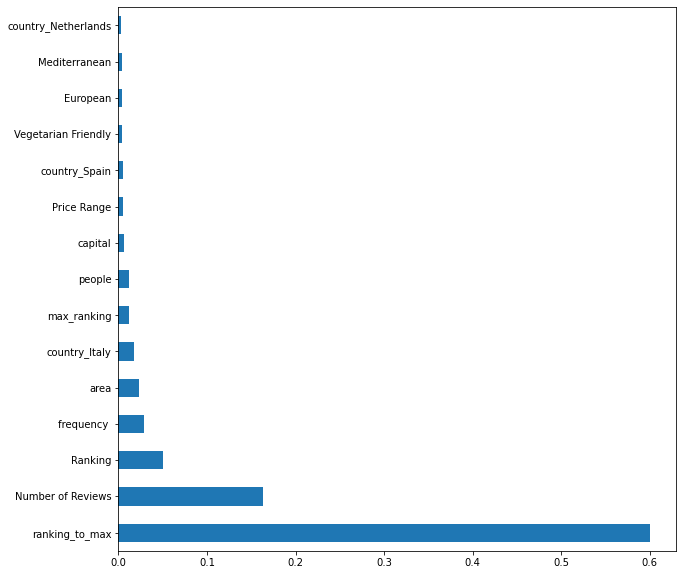

In [69]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [70]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Bar,Pub,European,Gluten Free Options,Vegetarian Friendly,Vegan Options,...,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,capital,people,frequency,area,max_ranking,ranking_to_max
6678,6279.0,2.5,18.0,0.0,1,1,0,0,0,0,...,0,0,0,0,1,2148327,0.000008,105.40,13986.0,0.448949
2568,6952.0,2.5,10.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,1620343,0.000006,101.40,7796.0,0.891739
958,2784.0,2.5,9.0,0.0,0,0,1,0,1,0,...,0,0,0,0,1,505526,0.000018,100.05,3717.0,0.748991
3834,11578.0,2.5,12.0,0.0,0,0,1,0,1,0,...,0,0,0,0,1,2148327,0.000006,105.40,13986.0,0.827828
1653,1007.0,4.0,328.0,0.0,0,0,1,1,1,1,...,0,0,0,0,1,8961989,0.000037,1572.00,16444.0,0.061238
9419,2129.0,1.0,50.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1399860,0.000036,181.76,6270.0,0.339553
5606,1177.0,2.5,364.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,516092,0.000705,47.87,2664.0,0.441817
8732,6612.0,2.5,27.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,8961989,0.000003,1572.00,16444.0,0.402092
181,7219.0,2.5,14.0,0.0,0,0,1,0,0,0,...,0,0,0,0,1,8961989,0.000002,1572.00,16444.0,0.439005
6668,4908.0,2.5,39.0,0.0,0,0,1,0,1,0,...,0,0,0,0,1,2870500,0.000014,1285.00,5948.0,0.825151


In [71]:
test_data = test_data.drop(['Rating'], axis=1)

In [72]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [73]:
predict_submission = round_rating(model.predict(test_data))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [74]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [75]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# Выводы

* Обработаны категориальные признаки в понятный для машины формат
* Дополнительно извлечены и сгенерированы новые признаки
* Подгружены дополнительные данные по стране, столице, населению и площади

Поставленные задачи решены. MAE: 0.18
